## Classification of cellular data set using provided mask
### Logistic regression

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import embed
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

import seaborn as sns

### Get and prepare data

In [3]:
# Read CSV file
# The masks have been subtracted from cell image using boolean as arg, better than using 0 as first try
df = pd.read_csv('data_masked.csv')

# make design matrix with all relative intensities
total = df['r'] + df['g'] + df['b']
X_g = (df['g']/total).values.reshape(-1,1) # reshape to make concatenate work
X_r = (df['r']/total).values.reshape(-1,1)
X_b = (df['b']/total).values.reshape(-1,1)
X_full = total.values.reshape(-1,1)
X_all = np.concatenate((X_r, X_g, X_b), axis=1)

# define classification labels
y = df['label']

# Print max min
print('\nMin max red:')
print(df['r'].min())
print(df['r'].max())

print('\nMin max green:')
print(df['g'].min())
print(df['g'].max())

print('\nMin max blue:')
print(df['b'].min())
print(df['b'].max())


Min max red:
52.52889584964761
240.28710903749783

Min max green:
42.10294475541495
245.72930706756523

Min max blue:
39.70040268456376
92.3551246537396


### Perform the regression 
Train and test are split using scikit function, not based on keywords as in the github example (is this cheating?)

In [4]:
def log_reg(X,y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate accuracy
    accuracy_all = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy_all * 100:.2f}%')
    
    # Calculate recall
    recall = recall_score(y_test, predictions)
    print(f'Recall: {recall * 100:.2f}%')
    
    # Calculate F1 score
    f1 = f1_score(y_test, predictions)
    print(f'F1 score: {f1 * 100:.2f}%')

    # model info
    #print(model.get_params())
    print(f'Intercept:{model.intercept_}')
    print(f'Coefficients: {model.coef_}')
    

print('\nRed channel:')
log_reg(X_r, y)

print('\nGreen channel:')
log_reg(X_g, y)

print('\nBlue channel:')
log_reg(X_b, y)

print('\nAll channels as three separate features:')
log_reg(X_all, y)

print('\nAll channels as one single feature:')
log_reg(X_full, y)


Red channel:
Accuracy: 81.62%
Recall: 67.85%
F1 score: 74.82%
Intercept:[-10.47290613]
Coefficients: [[25.80817873]]

Green channel:
Accuracy: 79.22%
Recall: 68.01%
F1 score: 72.49%
Intercept:[8.40807333]
Coefficients: [[-23.27920038]]

Blue channel:
Accuracy: 61.29%
Recall: 7.40%
F1 score: 13.33%
Intercept:[-1.53955784]
Coefficients: [[5.19910066]]

All channels as three separate features:
Accuracy: 85.44%
Recall: 81.67%
F1 score: 81.87%
Intercept:[-0.77975455]
Coefficients: [[ 20.68350015 -20.04747953  -0.63604834]]

All channels as one single feature:
Accuracy: 67.90%
Recall: 54.66%
F1 score: 57.82%
Intercept:[3.67798986]
Coefficients: [[-0.01528856]]


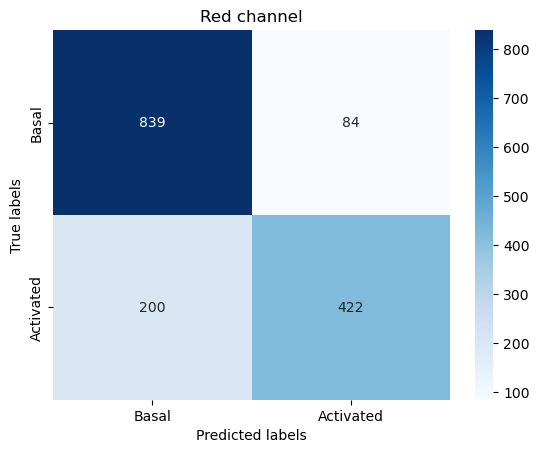

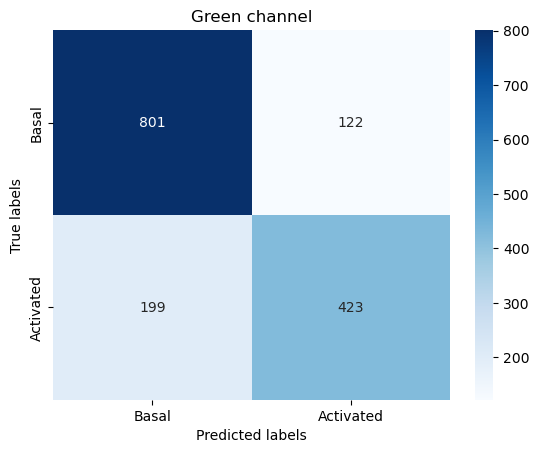

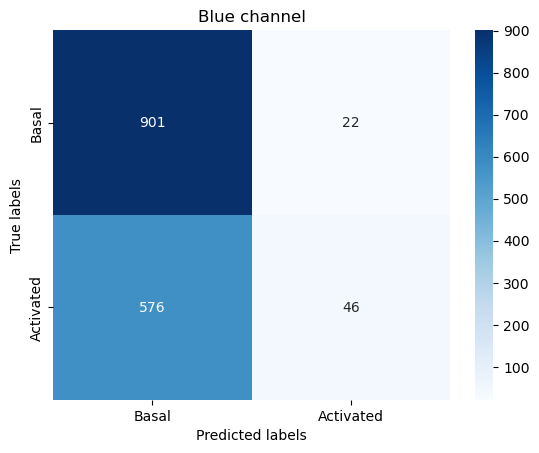

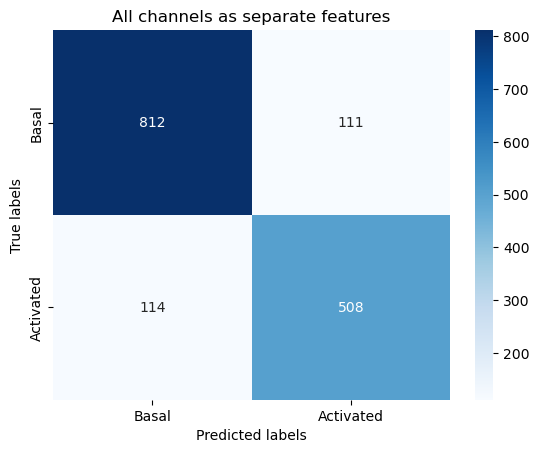

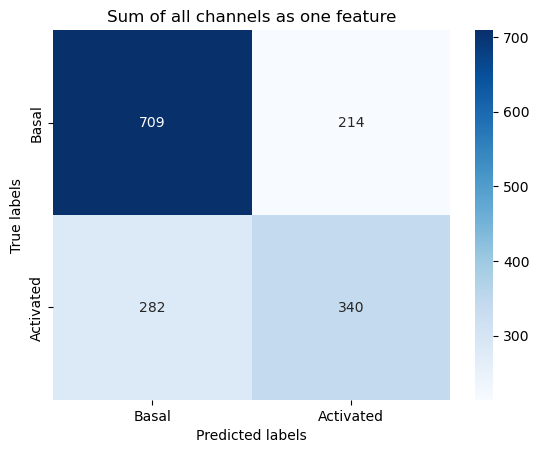

In [4]:
def log_reg(X,y,name):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Create confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Define custom tick labels
    tick_labels = ['Basal', 'Activated']
    
    # Plotting the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=tick_labels, yticklabels=tick_labels)
    
    # Setting labels, title, and ticks
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(name)
    plt.show()
    
#Red channel
log_reg(X_r, y, 'Red channel')

# Green channel
log_reg(X_g, y, 'Green channel')

# Blue channel
log_reg(X_b, y, 'Blue channel')

# All channels
log_reg(X_all, y, 'All channels as separate features')

# All channels
log_reg(X_full, y, 'Sum of all channels as one feature')

### CNN model



In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
from IPython import embed
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [53]:
# Prepare data

# Define image transformations
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
current_directory = os.getcwd()
root = current_directory + '/small'
dataset = ImageFolder(root=root, transform=transform)

train_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.2])

# Define batch size for loading images in each iteration
batch_size = 200

# Create a DataLoader for your dataset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [79]:
# binary output when using softmax
num_classes = 2

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Accuracy: 89.23%
Recall: 85.94%
F1 score: 86.63%


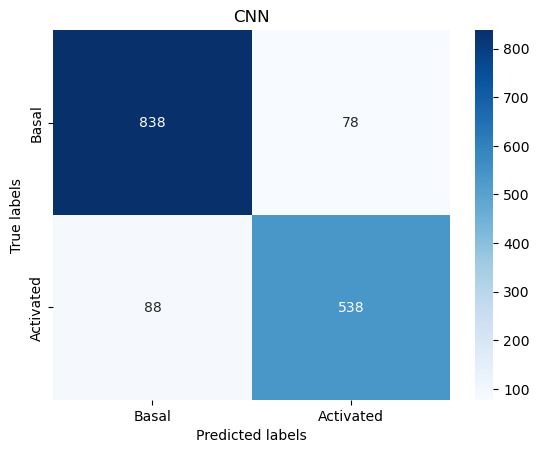

In [80]:
# define and load model
model = CNN()
model.load_state_dict(torch.load('model.pth'))    # saved from test run

predictions = []
targets = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.tolist())
        targets.extend(target.tolist())

# Calculate accuracy
accuracy = accuracy_score(targets, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate recall
recall = recall_score(targets, predictions)
print(f'Recall: {recall * 100:.2f}%')

# Calculate F1 score
f1 = f1_score(targets, predictions)
print(f'F1 score: {f1 * 100:.2f}%')


# Create confusion matrix
cm = confusion_matrix(targets, predictions)

# Define custom tick labels
tick_labels = ['Basal', 'Activated']

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
        xticklabels=tick_labels, yticklabels=tick_labels)

# Setting labels, title, and ticks
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('CNN')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

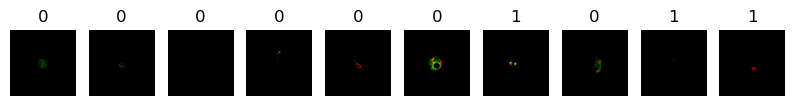

In [78]:
# Show a batch of images and labels

# Get images and labels
images, labels = next(iter(torch.utils.data.DataLoader(train_set, batch_size=10))) 

# Plot the images with their corresponding labels
fig, axs = plt.subplots(1, 10, figsize=(10, 2))
for i, ax in enumerate(axs):
    #unnormalize before plotting
    image = images[i].numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.set_title(str(labels[i].item()))
    ax.axis('off')
